# Part 6
# Author: Georgios Pligoropoulos < george@pligor.com >

In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from os import path, remove
import numpy as np
import pandas as pd
from csv import QUOTE_ALL
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
import shutil
from sklearn.metrics import r2_score
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import operator
from os.path import isfile, isdir, join
from os import getcwd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE, \
    MatrixFactorization, BiScaler
from math import floor
from scipy import stats

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
seed = 16011984
random_state = np.random.RandomState(seed=seed)
n_jobs = 1
%matplotlib inline

In [4]:
from advanced_one_hot_encoder import AdvancedOneHotEncoder

**Short sale** explained: http://www.investopedia.com/terms/r/real-estate-short-sale.asp

## Load Data

In [5]:
twin_cities_path = join(getcwd(), 'twin_cities.csv')
df = pd.read_csv(twin_cities_path, delimiter = ',', encoding='utf-8', quoting=QUOTE_ALL, index_col=0)
df.shape

(1111, 20)

## Drop redundant columns
State column does not hold any information since it is the same for all instances
Also we are dropping last sale date as we are advised to not use it but also because it contains lots of nulls

In [6]:
if 'STATE' in df.columns:
    df = df.drop(labels=['STATE'], axis=1)
if 'LastSaleDate' in df.columns:
    df = df.drop(labels=['LastSaleDate'], axis=1)
df.shape

(1111, 18)

### Keep columns for Price Regression

In [7]:
#Regression Columns
#CITY, ZIP, BEDS, BATHS, SQFT, LotSize, YearBuilt, ParkingSpots, HasGarage, LATITUDE, LONGITUDE, ShortSale
XX = df[
    ['CITY', 'ZIP', 'BEDS', 'BATHS', 'SQFT', 'LotSize', 'YearBuilt', 'ParkingSpots', 'HasGarage', 'LATITUDE',
     'LONGITUDE', 'ShortSale']
]
XX.shape

(1111, 12)

In [8]:
#target: ListPrice
yy = df['ListPrice']
yy.shape

(1111,)

### Numerify data

In [9]:
if XX['BATHS'].dtype == 'object':
    XX['BATHS'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['BATHS']]
XX['BATHS'].dtype

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


dtype('float64')

#### CITY

In [10]:
print len(XX['CITY'].unique())
XX['CITY'].unique()

6


array([u'St. Paul', u'Shoreview', u'Minneapolis', u'Woodbury',
       u'West St. Paul', u'Maplewood'], dtype=object)

In [11]:
if 'CITY' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='CITY')
XX.shape

(1111, 16)

#### ZIP

In [12]:
#comparing locations and zips lengths
print len(df['LOCATION'].unique())
print len(df['ZIP'].unique())

86
33


In [13]:
if 'ZIP' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='ZIP')
XX.shape

(1111, 47)

#### Year Built to Age

In [14]:
if 'YearBuilt' in XX.columns:
    XX['age'] = 2014 - XX['YearBuilt']
    XX.drop(labels='YearBuilt', axis=1, inplace=True)
assert 'age' in XX.columns
XX.shape

(1111, 47)

#### Has Garage to binary

In [15]:
XX['HasGarage'].unique()

array([u'Garage', u'No Garage'], dtype=object)

In [16]:
if 'Garage' in XX['HasGarage'].unique():
    XX['HasGarage'] = XX['HasGarage'] == 'Garage'
XX['HasGarage'].unique()

array([True, False], dtype=object)

#### Short Sale to binary

In [17]:
XX['ShortSale'].unique()

array([u'N', u'Y'], dtype=object)

In [18]:
if 'Y' in XX['ShortSale'].unique():
    XX['ShortSale'] = XX['ShortSale'] == 'Y'
XX['ShortSale'].unique()

array([False, True], dtype=object)

#### Latitude

In [19]:
if XX['LATITUDE'].dtype == 'object':
    XX['LATITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LATITUDE']]
XX['LATITUDE'].dtype

dtype('float64')

#### Longitude

In [20]:
if XX['LONGITUDE'].dtype == 'object':
    XX['LONGITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LONGITUDE']]
XX['LONGITUDE'].dtype

dtype('float64')

### Fill the Gaps
Rule of thumb of KNN to pick a neighborhood of 1%

In [21]:
k_factor = int(floor(len(XX) * 0.01))
k_factor

11

In [22]:
if sum(XX.isnull().sum()) > 0:
    XX[XX.columns] = KNN(k=k_factor).complete(XX.values)

Imputing row 1/1111 with 0 missing, elapsed time: 0.374
Imputing row 101/1111 with 1 missing, elapsed time: 0.376
Imputing row 201/1111 with 1 missing, elapsed time: 0.376
Imputing row 301/1111 with 0 missing, elapsed time: 0.377
Imputing row 401/1111 with 0 missing, elapsed time: 0.378
Imputing row 501/1111 with 0 missing, elapsed time: 0.378
Imputing row 601/1111 with 0 missing, elapsed time: 0.379
Imputing row 701/1111 with 0 missing, elapsed time: 0.379
Imputing row 801/1111 with 0 missing, elapsed time: 0.380
Imputing row 901/1111 with 0 missing, elapsed time: 0.380
Imputing row 1001/1111 with 0 missing, elapsed time: 0.381
Imputing row 1101/1111 with 0 missing, elapsed time: 0.381


In [23]:
sum(XX.isnull().sum())

0

# Question 6
We’d like to understand how listings compare with the population in their area. Take the
zip code data in the 2nd sheet and match against the house listing data. What zip codes
have the highest amount of listings per the population size? Show the top 10.

Separately, what zip code has the highest listing price per person? Google that zip code
and provide some hypothesis and examples as to why this might be true.

### Answer

#### join em

In [24]:
zip_path = join(getcwd(), 'zips.csv')
zipdf = pd.read_csv(zip_path, delimiter = ',', encoding='utf-8', quoting=QUOTE_ALL, index_col=0)
zipdf.shape

(33092, 1)

In [25]:
zipdf.columns

Index([u'Population_2010_Census'], dtype='object')

In [26]:
zipdf.describe()

,Population_2010_Census
count,33092.000000
mean,9329.745286
std,13656.525969
min,0.000000
25%,722.000000
50%,2750.500000
75%,12749.250000
max,113916.000000


In [27]:
zipdf.sample(n=5, random_state=random_state)

,Population_2010_Census
ZipCode,
45247,22082
39560,16844
94503,19681
42064,8421
56137,1149


In [28]:
# aa = zipdf.loc[df['ZIP']]
# bb = np.array([zipdf.loc[curzip] for curzip in df['ZIP']])
# np.all(aa == bb)

In [29]:
population = zipdf.loc[df['ZIP']]
population.shape, np.sum(population.isnull())

((1111, 1), Population_2010_Census    0
 dtype: int64)

In [30]:
df['pop'] = population.values.flatten()
df.sample(random_state=random_state)

,ADDRESS,CITY,ZIP,ListPrice,BEDS,BATHS,LOCATION,SQFT,LotSize,YearBuilt,ParkingSpots,HasGarage,DOM,SoldPrev,Realty,LATITUDE,LONGITUDE,ShortSale,pop
ID,,,,,,,,,,,,,,,,,,,
4437344,862 3rd St E,St. Paul,55106,47000,3,1,Dayton's Bluff,1000,4791.0,1884,1,Garage,22,N,Re/Max Prodigy,"44,95649","-93,064133",N,52730


In [31]:
XX['pop'] = population.values.flatten()
XX.sample(random_state=random_state)

,BEDS,BATHS,SQFT,LotSize,ParkingSpots,HasGarage,LATITUDE,LONGITUDE,ShortSale,CITY_0,...,ZIP_24,ZIP_25,ZIP_26,ZIP_27,ZIP_28,ZIP_29,ZIP_30,ZIP_31,age,pop
ID,,,,,,,,,,,,,,,,,,,,,
4435057,4.0,2.0,1705.0,5224.319625,3.0,1.0,44.892963,-93.265678,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,64.0,24875


#### highest amount of listing per population size for a single zip code
In other words we want to count how many listings we have and how large is the population for a particular zip code

In [32]:
sample_zip = 55106

In [33]:
num_listings = df[df['ZIP'] == sample_zip].count()[0]
num_listings

133

In [34]:
total_pop = df[df['ZIP'] == sample_zip]['pop'][0]
total_pop

52730

In [35]:
listings_per_zip = df.groupby(['ZIP']).count().iloc[:, :1].rename(columns={"ADDRESS": "count_listings"})
listings_per_zip.sample(n=5, random_state=random_state)

,count_listings
ZIP,
55126,2
55419,59
55129,1
55411,45
55413,9


In [36]:
pop_per_zip = df.groupby(['ZIP']).first()['pop'].to_frame(name='population')
#.rename(columns={"ADDRESS": "population"})

pop_per_zip.sample(n=5, random_state=random_state)

,population
ZIP,
55421,27035
55106,52730
55101,5592
55404,27121
55104,43248


In [37]:
listings_per_pop = listings_per_zip['count_listings'] / pop_per_zip['population']
listings_per_pop.sample(n=5, random_state=random_state)

ZIP
55405    0.000519
55419    0.002234
55108    0.001021
55129    0.000053
55107    0.002098
dtype: float64

In [38]:
temp_df = (listings_per_pop.sort_values(ascending=False).to_frame('listings_per_population_per_zip_%') * 100).reset_index(
).rename(columns = {
        'listings_per_population_per_zip_%': "Percentage of Number of Listings per Population"
    }
)[:10].set_index(np.arange(1,11))
temp_df

,ZIP,Percentage of Number of Listings per Population
1,55412,0.483114
2,55410,0.289555
3,55106,0.252228
4,55417,0.237186
5,55406,0.224215
6,55419,0.223434
7,55107,0.209800
8,55105,0.186259
9,55116,0.184479
10,55104,0.182667


In [39]:
temp_df.to_csv('exer1_quest6.csv', quoting=QUOTE_ALL, encoding='utf-8')

### What zip code has the highest listing price per person?

In [40]:
max_price_per_zip = df.groupby(['ZIP']).max()['ListPrice'].to_frame(name='max_price')
print len(max_price_per_zip)
max_price_per_zip

33


,max_price
ZIP,
55101,99900
55102,2225000
55103,177500
55104,1195000
55105,2990000
55106,389000
55107,259900
55108,294900
55113,214000


In [41]:
dic = OrderedDict()
for ind, row in df.iterrows():
    bedrooms = row['BEDS'] #+ 1 if we could consider a couple living in one bedroom
    curzip = row['ZIP']
    if curzip in dic:
        if row['ListPrice'] > dic[curzip]['max_price']:
            dic[curzip] = {"max_price": row['ListPrice'], "bedrooms": bedrooms,
                          "max_price_per_bedroom": row['ListPrice']/bedrooms}
    else:
        dic[curzip] = {"max_price": row['ListPrice'], "bedrooms": bedrooms,
                       "max_price_per_bedroom": row['ListPrice']/bedrooms }

#beds_per_zip_for_max_price = df[max_price_per_zip['max_price'] == df['ListPrice']]
#len(beds_per_zip_for_max_price)
dic

OrderedDict([(55113,
              {'bedrooms': 3,
               'max_price': 214000,
               'max_price_per_bedroom': 71333.33333333333}),
             (55104,
              {'bedrooms': 6,
               'max_price': 1195000,
               'max_price_per_bedroom': 199166.66666666666}),
             (55106,
              {'bedrooms': 3,
               'max_price': 389000,
               'max_price_per_bedroom': 129666.66666666667}),
             (55126,
              {'bedrooms': 4,
               'max_price': 483900,
               'max_price_per_bedroom': 120975.0}),
             (55418,
              {'bedrooms': 5,
               'max_price': 385000,
               'max_price_per_bedroom': 77000.0}),
             (55116,
              {'bedrooms': 4,
               'max_price': 1325000,
               'max_price_per_bedroom': 331250.0}),
             (55103,
              {'bedrooms': 2,
               'max_price': 177500,
               'max_price_per_bedroom': 88750.0})

In [42]:
price_df = pd.DataFrame(index=dic.keys(), data=dic.values())
price_df.shape

(33, 3)

In [43]:
price_df.sort_values(by='max_price_per_bedroom', ascending=False)

,bedrooms,max_price,max_price_per_bedroom
55416,4,3775000,943750.000000
55410,5,4650000,930000.000000
55405,5,3750000,750000.000000
55105,4,2990000,747500.000000
55408,4,1995000,498750.000000
55409,4,1675000,418750.000000
55102,6,2225000,370833.333333
55116,4,1325000,331250.000000
55419,7,1695000,242142.857143
55104,6,1195000,199166.666667


There are links that support that this analysis is correct:
https://www.zillow.com/homedetails/3305-E-Calhoun-Pkwy-Minneapolis-MN-55408/1717992_zpid/

https://www.zillow.com/homedetails/2424-W-Lake-Of-The-Isles-Pkwy-Minneapolis-MN-55405/1990862_zpid/

https://www.zillow.com/homedetails/2603-Newton-Ave-S-Minneapolis-MN-55405/2001002_zpid/

https://www.zillow.com/homedetails/4243-Fremont-Ave-S-Minneapolis-MN-55409/1771866_zpid/

### Alternatively by taking the median values per area

In [44]:
median_per_zip = df.groupby(['ZIP']).median()[['ListPrice', 'BEDS']]
#print len(max_price_per_zip)
median_per_zip.sample(n=5)

,ListPrice,BEDS
ZIP,,
55419,319900.0,3.0
55116,329900.0,3.0
55117,139900.0,3.0
55421,147400.0,3.5
55408,320500.0,3.0


In [45]:
median_per_zip['price_per_bed'] = median_per_zip['ListPrice'] / median_per_zip['BEDS']

In [46]:
temp_df = median_per_zip.sort_values(by='price_per_bed', ascending=False)
temp_df.head(10)

,ListPrice,BEDS,price_per_bed
ZIP,,,
55405,1465000.0,5.0,293000.000000
55416,1049450.0,4.0,262362.500000
55410,754950.0,4.0,188737.500000
55129,319000.0,2.0,159500.000000
55105,360000.0,3.0,120000.000000
55126,464400.0,4.0,116100.000000
55116,329900.0,3.0,109966.666667
55408,320500.0,3.0,106833.333333
55419,319900.0,3.0,106633.333333


In [47]:
temp_df.to_csv('exer1_quest6b.csv', encoding='utf-8', quoting=QUOTE_ALL)

#### comparison

In [111]:
median_top = median_per_zip.sort_values(by='price_per_bed', ascending=False)[:10]
max_top = price_df.sort_values(by='max_price_per_bedroom', ascending=False)[:10]
median_top.shape, max_top.shape

((10, 3), (10, 3))

In [112]:
inds1 = median_top.index
inds2 = max_top.index

In [113]:
set(inds1).difference(inds2)

{55126, 55129}

In [114]:
set(inds2).difference(inds1)

{55102, 55104}

In [115]:
set(inds2).intersection(inds1)

{55105, 55116, 55405, 55408, 55409, 55410, 55416, 55419}

We notice that the two metrics agree at 8/10 or 4/5 cases for the top most expensive houses in Minneapolis

This heatmap comes in agreement: https://www.trulia.com/home_prices/Minnesota/Minneapolis-heat_map/

#### compare

In [127]:
max_top_df = max_top.rename(columns={
        'max_price_per_bedroom': 'price_per_bed',
    })['price_per_bed'].reset_index().rename(columns={'index': 'ZIP'})
max_top_df['type'] = 'maximum'
max_top_df.shape

(10, 3)

In [128]:
median_top_df = median_top['price_per_bed'].reset_index()
median_top_df['type'] = 'median'
median_top_df.shape

(10, 3)

In [131]:
merged_df = pd.concat((max_top_df, median_top_df), axis=0)
merged_df = merged_df.rename(columns={'price_per_bed': 'Listing Price per Bed'})
merged_df.head(1)

,ZIP,Listing Price per Bed,type
0,55416,943750.0,maximum


In [137]:
sns.set(font_scale=1.5)

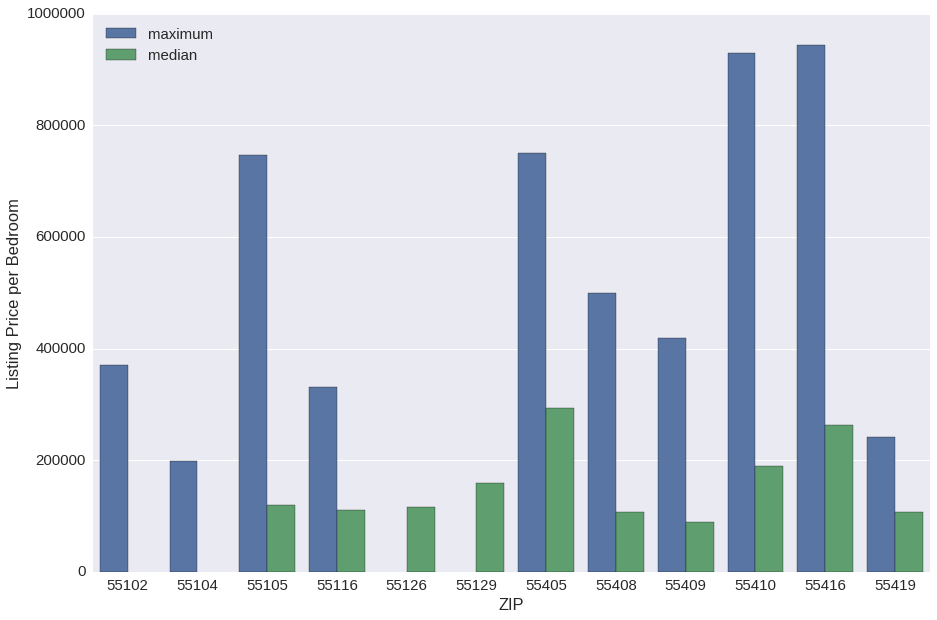

In [143]:
plt.figure(figsize=(15,10))
sns.barplot(data=merged_df, x='ZIP', y='Listing Price per Bed', hue='type', estimator=lambda xx: xx)
plt.ylabel('Listing Price per Bedroom')
plt.legend(loc='upper left')
plt.show()

# How to guess the number of people per bed?

So let's see first what is the most prevelant bedroom per zip code

In [52]:
XX.shape

(1111, 48)

In [55]:
sums = df.isnull().sum()
sums = sums[sums > 0]
sums

BATHS         1
LOCATION      6
LotSize      64
LATITUDE      6
LONGITUDE     6
dtype: int64

In [56]:
assert df['ZIP'].isnull().sum() == 0
assert df['BEDS'].isnull().sum() == 0

In [59]:
from matplotlib import rcParams

In [60]:
rcParams['figure.figsize'] = 15,7

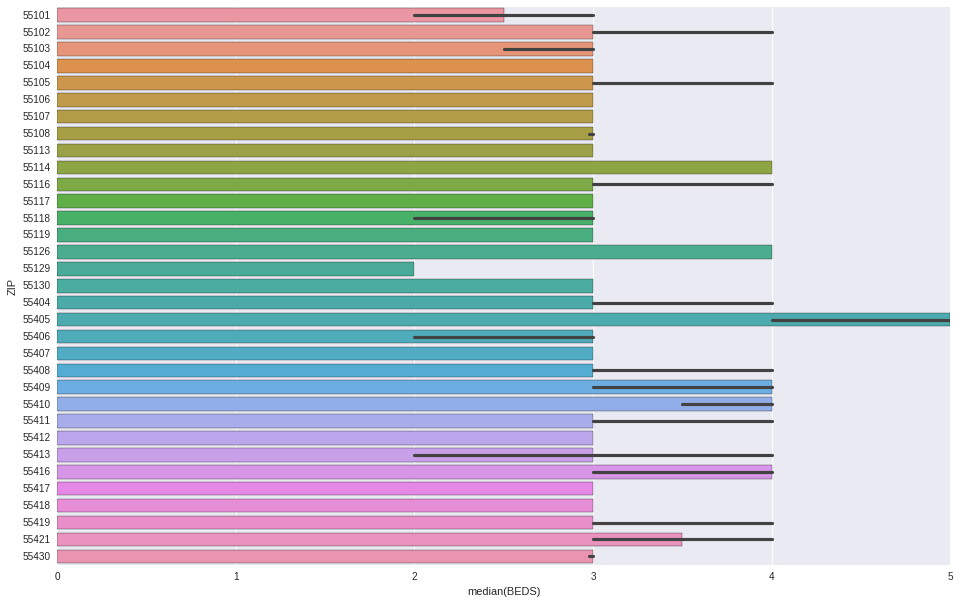

In [64]:
plt.figure(figsize=(16, 10))
sns.barplot(data=df, x = 'BEDS', y='ZIP', orient='horizontal', estimator=np.median)
plt.show()

In [69]:
df[df['ZIP']==55421]

,ADDRESS,CITY,ZIP,ListPrice,BEDS,BATHS,LOCATION,SQFT,LotSize,YearBuilt,ParkingSpots,HasGarage,DOM,SoldPrev,Realty,LATITUDE,LONGITUDE,ShortSale,pop
ID,,,,,,,,,,,,,,,,,,,
4435756,694 37th Ave NE,Minneapolis,55421,174900,3,2,Columbia Park,2084,5227.0,1925,2,Garage,36,N,RE/MAX Specialists,"45,035309","-93,252892",N,27035
4415169,704 37th Ave NE,Minneapolis,55421,119900,4,"1,5",Columbia Park,1304,5227.0,1939,2,Garage,119,N,"Counselor Realty, Inc.","45,035301","-93,252388",N,27035


In [66]:
df[np.round(df['BEDS']) == df['BEDS'] ].shape

(1111, 19)

If the areas where you have as median value the three bedrooms you also have the population of the area.  
Therefore you could assign a weight: the population per bedroom  
You do the same for the rest of the areas  
And then you have a function of population per bedroom

In [72]:
zip_beds = df.groupby('ZIP').median()['BEDS']
zip_beds

ZIP
55101    2.5
55102    3.0
55103    3.0
55104    3.0
55105    3.0
55106    3.0
55107    3.0
55108    3.0
55113    3.0
55114    4.0
55116    3.0
55117    3.0
55118    3.0
55119    3.0
55126    4.0
55129    2.0
55130    3.0
55404    3.0
55405    5.0
55406    3.0
55407    3.0
55408    3.0
55409    4.0
55410    4.0
55411    3.0
55412    3.0
55413    3.0
55416    4.0
55417    3.0
55418    3.0
55419    3.0
55421    3.5
55430    3.0
Name: BEDS, dtype: float64

In [107]:
assert np.all(pop_per_zip.index == zip_beds.index)
pop_per_bed = pd.Series(data = pop_per_zip.values.flatten() / zip_beds.values.flatten(), index=pop_per_zip.index)
pop_per_bed

ZIP
55101     2236.800000
55102     6069.000000
55103     4330.333333
55104    14416.000000
55105     9485.000000
55106    17576.666667
55107     4925.333333
55108     4896.000000
55113    12998.000000
55114      775.000000
55116     7950.333333
55117    13883.000000
55118     9182.666667
55119    12988.666667
55126     6285.000000
55129     9348.500000
55130     5858.333333
55404     9040.333333
55405     3082.200000
55406    10704.000000
55407    12627.000000
55408     9993.666667
55409     2903.750000
55410     4835.000000
55411     9142.666667
55412     7382.666667
55413     4311.333333
55416     7256.750000
55417     8291.666667
55418     9824.000000
55419     8802.000000
55421     7724.285714
55430     7169.333333
dtype: float64

**Alternatively** we could do it manually, to create a map according to our domain knowledge

In [108]:
df['BEDS'].unique()

array([3, 4, 2, 5, 7, 6, 1, 8])

In [109]:
bed_people = {
    1: 1.5, #one bedroom, one or two people
    2: 2.5, #two people or a couple and a child
    3: 3.5, #3 people or a couple and two kids
    4: 4, #most likely 4 people
    5: 4.5, #most likely 4 people and a guest room or 5 people
    6: 5, #most likely 5 people and a guest room
    7: 5.5, #five or six people
    8: 6, #six people on average
}

# Yet Another Idea

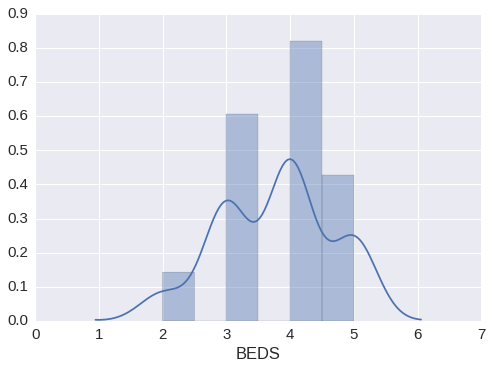

In [146]:
sns.distplot(df[df['ZIP']==55410]['BEDS'])
plt.show()

And we assign the population of this area to the bedrooms according to the listing. As if the listings were representative of the houses that in general exist in the area

In [148]:
beds_of_area = df[df['ZIP']==55410]['BEDS']

In [153]:
unique_beds = np.sort(beds_of_area.unique())
unique_beds

array([2, 3, 4, 5])

In [154]:
weights = np.histogram(beds_of_area, bins=len(beds_of_area.unique()))[0]
weights

array([ 4, 17, 23, 12])

In [162]:
cur_pop = pop_per_zip.loc[55410].values[0]
cur_pop

19340

In [160]:
weights

array([ 4, 17, 23, 12])

In [164]:
weighted_pop_per_bed = ((weights * cur_pop) / np.sum(weights)) / unique_beds
weighted_pop_per_bed

array([  690.71428571,  1957.02380952,  1985.80357143,   828.85714286])

In [167]:
dict(zip(unique_beds, weighted_pop_per_bed))

{2: 690.71428571428567,
 3: 1957.0238095238094,
 4: 1985.8035714285713,
 5: 828.85714285714289}

In [168]:
def get_weighted_pop_per_bed(zip_code):
    beds_of_area = df[df['ZIP']==zip_code]['BEDS']
    unique_beds = np.sort(beds_of_area.unique())
    weights = np.histogram(beds_of_area, bins=len(beds_of_area.unique()))[0]
    cur_pop = pop_per_zip.loc[zip_code].values[0]
    weighted_pop_per_bed = ((weights * cur_pop) / np.sum(weights)) / unique_beds
    return dict(zip(unique_beds, weighted_pop_per_bed))

In [174]:
cur_weighted_pop_per_bed = get_weighted_pop_per_bed(55410)
cur_weighted_pop_per_bed

{2: 690.71428571428567,
 3: 1957.0238095238094,
 4: 1985.8035714285713,
 5: 828.85714285714289}

In [171]:
zip_code = 55410

In [181]:
#for every zip code take all the prices and multiply them with the corresponding weight for the bedrooms in hand
#then take the median value of the results
#for zip_code in pop_per_zip.keys()
def get_median_value(zip_code, cur_weighted_pop_per_bed):
    return np.median([series['ListPrice'] * cur_weighted_pop_per_bed[series['BEDS']]
    for ind, series in df[df['ZIP'] == zip_code].iterrows()])

In [182]:
zips_weighted = OrderedDict()

In [190]:
for zip_code in pop_per_zip.index:
    cur_weighted_pop_per_bed = get_weighted_pop_per_bed(zip_code)
    zips_weighted[zip_code] = get_median_value(zip_code, cur_weighted_pop_per_bed)

In [193]:
ranks = pd.Series(index=zips_weighted.keys(), data=zips_weighted.values())
ranks.head(10)

55101    7.094850e+07
55102    2.329039e+08
55103    1.459709e+08
55104    6.793768e+08
55105    8.048828e+08
55106    7.305880e+08
55107    2.333178e+08
55108    2.936131e+08
55113    2.781572e+09
55114    1.162500e+08
dtype: float64

In [196]:
top_10 = ranks.sort_values(ascending=False).index[:10]
top_10

Int64Index([55129, 55416, 55126, 55113, 55408, 55405, 55417, 55407, 55404,
            55118],
           dtype='int64')